In [127]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [128]:
def f(x):
    return 3*x**2 - 4*x + 5

In [129]:
f(3.0)

20.0

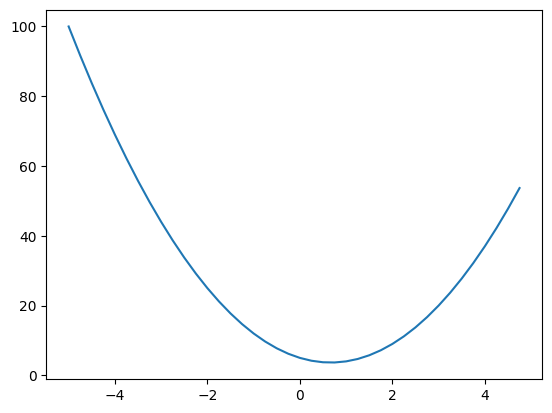

In [130]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [131]:
h = 0.0000000001
x = -3.0
(f(x+h) - f(x)) / h

-21.999966293151374

In [132]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [133]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [134]:
import math

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        # data is the actual scalar number stored in this node
        # example: if you do a = Value(2.0), then a.data == 2.0
        self.data = data

        # grad will store the derivative of the final output w.r.t. this node
        # think: "if i nudge this node's data a tiny bit, how much does the final answer change?"
        # it starts at 0 and we add into it during backprop (because multiple paths can contribute)
        self.grad = 0.0

        # _backward is a function that knows how to push gradients to this node's inputs
        # for leaf nodes (like Value(2.0)), there is no operation, so it does nothing
        self._backward = lambda: None

        # _prev holds the input nodes used to create this node (its parents in the graph)
        # we use a set so we do not store duplicates
        # example: if c = a * b, then c._prev contains a and b
        self._prev = set(_children)

        # _op is just a string describing what operation made this node (for debugging/visualization)
        # example: '+', '*', 'tanh', 'exp', '**2'
        self._op = _op

        # label is optional and just helps you name nodes when debugging
        self.label = label

    def __repr__(self):
        # controls what you see when you print a Value
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # this lets you do:
        #   value + value
        #   value + number
        # if other is a raw number, wrap it into a Value so everything is consistent
        other = other if isinstance(other, Value) else Value(other)

        # forward pass:
        # compute the new value's data and remember the two inputs (self, other)
        # also store '+' so we know how it was made
        out = Value(self.data + other.data, (self, other), '+')
        
        # backward pass:
        # out = self + other
        # local derivatives:
        #   dout/dself = 1
        #   dout/dother = 1
        #
        # chain rule idea:
        # if final output is L, we will eventually know dL/dout (that is out.grad)
        # then:
        #   dL/dself  += dout/dself  * dL/dout = 1 * out.grad
        #   dL/dother += dout/dother * dL/dout = 1 * out.grad
        #
        # we use "+=" because self and other might feed into the final output through
        # multiple paths, and we must add all contributions
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        # attach this rule to the output node so when we call backward(),
        # the output node knows how to distribute its gradient to its inputs
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        # handles: number + value
        # python will call value.__radd__(number) if number.__add__(value) fails
        return self + other
    
    def __mul__(self, other):
        # supports:
        #   value * value
        #   value * number
        other = other if isinstance(other, Value) else Value(other)

        # forward pass:
        # compute product and store parents
        out = Value(self.data * other.data, (self, other), '*')

        # backward pass:
        # out = self * other
        # local derivatives:
        #   dout/dself = other.data
        #   dout/dother = self.data
        #
        # chain rule:
        #   dL/dself  += (dout/dself)  * (dL/dout) = other.data * out.grad
        #   dL/dother += (dout/dother) * (dL/dout) = self.data  * out.grad
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        # handles: number * value
        return self * other
    
    def __pow__(self, other):
        # supports powers like:
        #   a ** 2
        #   a ** -1
        # but not:
        #   a ** b  (where b is a Value)
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"

        # forward:
        # out = self.data ** other
        out = Value(self.data ** other, (self,), f'**{other}')

        # backward:
        # out = a^p
        # local derivative:
        #   dout/da = p * a^(p-1)
        #
        # chain rule:
        #   dL/da += (p * a^(p-1)) * dL/dout
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward
        return out

    def __truediv__(self, other):
        # define division using power so we do not have to write a separate backward rule:
        # a / b = a * (b^-1)
        #
        # important: this depends on __pow__ and __mul__ already having correct backward logic
        return self * (other ** -1)
    
    def __neg__(self):
        # unary minus:
        # -a = a * -1
        #
        # again: this reuses multiplication's backward logic
        return self * -1
    
    def __sub__(self, other):
        # subtraction:
        # a - b = a + (-b)
        #
        # reuses add + neg logic
        return self + (-other)

    def tanh(self):
        # forward:
        # compute tanh(self.data)
        x = self.data

        # tanh(x) can be computed using exponentials
        # t is a plain python float here (not a Value), because it is the forward result
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)

        # wrap it into a Value node and remember self as its parent
        out = Value(t, (self,), 'tanh')

        # backward:
        # if out = tanh(x), then:
        #   dout/dx = 1 - tanh(x)^2
        # and tanh(x) is exactly t that we already computed
        #
        # chain rule:
        #   dL/dx += (1 - t^2) * dL/dout
        def _backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward
        return out
    
    def exp(self):
        # forward:
        # out = exp(x)
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        # backward:
        # d/dx exp(x) = exp(x)
        # and exp(x) is out.data
        #
        # chain rule:
        #   dL/dx += out.data * dL/dout
        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        # this runs backprop and fills in .grad for every node that influences this node
        #
        # key idea:
        # each node stores a _backward() function that knows how to push its gradient
        # to its parents. but we must call these in the correct order:
        # we must backprop from the final output back to the leaves.
        #
        # to do that safely, we build a topological ordering of the graph:
        # parents come before the node that depends on them.
        # then we walk that ordering backwards.

        topo = []
        visited = set()

        def build_topo(v):
            # this does a depth-first search (dfs)
            # it ensures we visit all parents of v before we add v to topo
            #
            # visited avoids infinite loops and avoids repeating nodes
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        # build topo list starting from the output node (self)
        build_topo(self)

        # the gradient of the output w.r.t itself is 1
        # example: if L is the final output, dL/dL = 1
        self.grad = 1.0

        # now go backwards and apply each node's local backward rule
        # at this point, node.grad is already known (it was accumulated by nodes after it)
        # and node._backward() will push that gradient to node's parents
        for node in reversed(topo):
            node._backward()


In [135]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

In [136]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [137]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label= "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [138]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# neuron output
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'
o.backward()

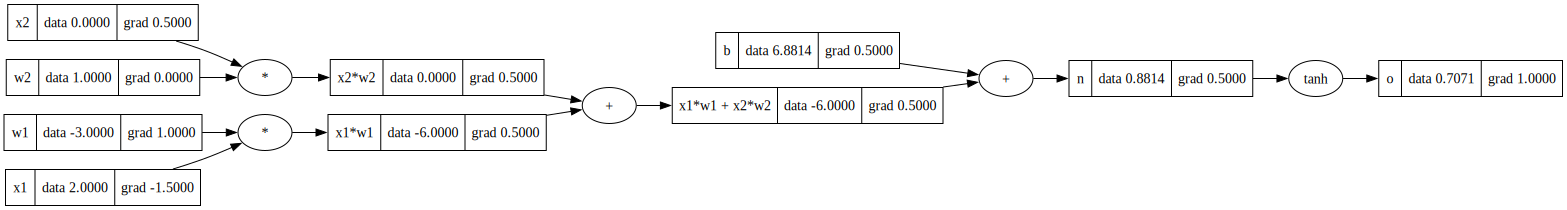

In [139]:
draw_dot(o)

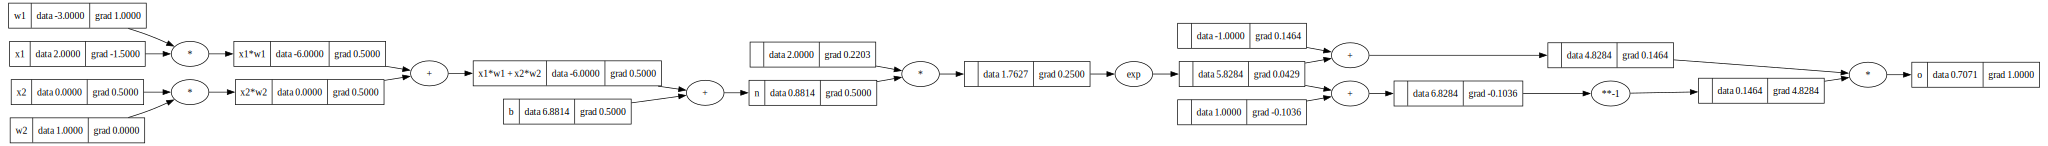

In [140]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# neuron output
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label='o'
o.backward()
draw_dot(o)

In [141]:
import torch 

In [142]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [143]:
import random

class Neuron:
    def __init__(self, nin):
        # nin = number of inputs coming into this neuron
        #
        # this neuron will compute:
        #   out = tanh(w1*x1 + w2*x2 + ... + wnin*xnin + b)
        #
        # self.w is the list of weights (one weight per input)
        # each weight is a value so it can store data and a gradient for learning
        self.w = []
        for _ in range(nin):
            self.w.append(Value(random.uniform(-1, 1)))

        # self.b is the bias term (also a value so it can learn)
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # this lets you "call" the neuron like a function:
        #   y = n(x)
        #
        # x is a list of inputs for this neuron, one per weight
        # usually these inputs are value objects (so gradients can flow),
        # but they can also be plain numbers if your value class wraps them elsewhere

        # zip(self.w, x) pairs each weight with its matching input:
        # (w1, x1), (w2, x2), ...
        #
        # wi * xi builds a value node for each multiplication, meaning:
        # - forward: multiply the numbers
        # - backward: know how to send gradients to wi and xi
        #
        # the generator expression produces: (w1*x1, w2*x2, ..., wnin*xnin)
        #
        # sum(..., self.b) starts the sum at the bias:
        # so this becomes:
        #   act = b + (w1*x1) + (w2*x2) + ...
        #
        # act is the "activation before nonlinearity" (sometimes called pre-activation)
        act = self.b
        for wi, xi in zip(self.w, x):
            act = act + (wi * xi)

        # apply the nonlinearity
        # out is a value node that remembers it came from tanh(act)
        # and has a backward rule: d/dact tanh(act) = 1 - tanh(act)^2
        out = act.tanh()

        return out
    
    def parameters(self):
        # return all learnable parameters in this neuron
        # these are exactly the weights plus the bias
        params = []
        for wi in self.w:
            params.append(wi)
        params.append(self.b)
        return params
    

class Layer:
    def __init__(self, nin, nout):
        # nin = number of inputs each neuron in this layer expects
        # nout = number of neurons in this layer (so number of outputs of this layer)
        #
        # if you imagine this as a matrix:
        # - this layer takes a vector of length nin
        # - it outputs a vector of length nout
        self.neurons = []
        for _ in range(nout):
            self.neurons.append(Neuron(nin))

    def __call__(self, x):
        # run the same input x through every neuron
        # each neuron returns one value output
        outs = []
        for n in self.neurons:
            outs.append(n(x))

        # if this layer has only one neuron, return a single value (not a list)
        # this is just a convenience so the last layer can return a scalar
        if len(outs) == 1:
            return outs[0]
        else:
            return outs
    
    def parameters(self):
        # collect parameters from every neuron in this layer
        #
        # for each neuron, neuron.parameters() gives [w1, w2, ..., b]
        # we flatten all those lists into one big list
        params = []
        for n in self.neurons:
            neuron_params = n.parameters()
            for p in neuron_params:
                params.append(p)
        return params


class MLP:
    def __init__(self, nin, nouts):
        # nin = number of inputs to the whole network
        # nouts = list describing the size of each layer's output
        # example:
        #   mlp(3, [4, 4, 1]) means:
        #   - input dimension = 3
        #   - layer 1: 3 -> 4
        #   - layer 2: 4 -> 4
        #   - layer 3: 4 -> 1
        #
        # sz becomes [nin, 4, 4, 1] in that example
        sz = [nin]
        for nout in nouts:
            sz.append(nout)

        # build each layer:
        # layer i takes sz[i] inputs and outputs sz[i+1] values
        self.layers = []
        for i in range(len(nouts)):
            self.layers.append(Layer(sz[i], sz[i + 1]))

    def __call__(self, x):
        # forward pass through the whole network
        #
        # start with input x
        # pass it through layer 1 -> layer 2 -> ... -> last layer
        #
        # note:
        # - after a layer, x becomes either a list of value outputs (hidden layers)
        # - or a single value output (if the final layer has nout=1)
        for layer_obj in self.layers:
            x = layer_obj(x)
        return x
    
    def parameters(self):
        # collect every learnable parameter in the entire network
        # flatten:
        #   all layers -> all neurons -> all weights and biases
        params = []
        for layer_obj in self.layers:
            layer_params = layer_obj.parameters()
            for p in layer_params:
                params.append(p)
        return params

In [144]:
# example input: 3 numbers because this mlp was built with nin=3
x = [2.0, 3.0, -1.0]

# build a network:
# - 3 inputs
# - first layer outputs 4 values
# - second layer outputs 4 values
# - last layer outputs 1 value
n = MLP(3, [4, 4, 1])

# run a forward pass:
# this pushes x through each layer, doing:
# - weighted sums + bias inside each neuron
# - tanh activation after each neuron
#
# the return value here is a single Value object (because the last layer has 1 neuron)
# and its .data is the final number produced by the network
n(x)

Value(data=0.18995814499699826)

In [145]:
# xs is your training inputs (your "x values")
# it is a list of 4 examples (so 4 training rows)
xs = [
    # example 1: 3 input numbers (because your mlp was made with nin=3)
    [2.0, 3.0, -1.0],

    # example 2: another set of 3 inputs
    [3.0, -1.0, 0.5],

    # example 3: another set of 3 inputs
    [0.5, 1.0, 1.0],

    # example 4: another set of 3 inputs
    [1.0, 1.0, -1.0],
]

# ys is your training targets (your "correct answers")
# it lines up with xs by index:
# - xs[0] should produce ys[0]
# - xs[1] should produce ys[1]
# - xs[2] should produce ys[2]
# - xs[3] should produce ys[3]
#
# here the targets are +1 or -1, which matches well with tanh output
# because tanh outputs values between -1 and 1
ys = [1.0, -1.0, -1.0, 1.0]


In [146]:
# run training for 20 steps (also called 20 iterations or 20 epochs here)
for k in range(20):

    # ----------------------------
    # forward pass
    # ----------------------------

    # make predictions for every training input in xs
    # for each x (a list of 3 numbers), n(x) returns a Value (the model's output)
    ypred = []
    for x in xs:
        ypred.append(n(x))

    # compute the total loss over the whole dataset
    # this uses squared error:
    #   (predicted - target)^2
    #
    # zip(ys, ypred) pairs up:
    #   (ys[0], ypred[0]), (ys[1], ypred[1]), ...
    #
    # loss will be a Value, not a float, because all math uses Value objects
    # (that is what lets gradients be computed automatically)
    loss = 0
    for ygt, yout in zip(ys, ypred):
        error = yout - ygt      # difference between prediction and correct answer
        loss = loss + (error ** 2)  # add squared error to the running total

    # ----------------------------
    # backward pass
    # ----------------------------

    # before doing backprop, clear old gradients from the previous step
    # if you do not reset them, gradients would keep adding up across steps
    for p in n.parameters():
        p.grad = 0.0

    # run backprop starting from loss
    # after this, every parameter p will have p.grad filled in
    # (p.grad is "how loss changes if we change this parameter a tiny bit")
    loss.backward()

    # ----------------------------
    # update (gradient descent)
    # ----------------------------

    # gradient descent rule:
    # move parameters slightly in the direction that makes loss smaller
    #
    # p.data = p.data - learning_rate * p.grad
    # here learning_rate is 0.1
    for p in n.parameters():
        p.data += -0.1 * p.grad

    # print the step number and the current loss value (as a normal python number)
    print(k, loss.data)

0 5.587426586248865
1 3.637264323196489
2 3.135667201927352
3 2.7636575311319516
4 2.437188754188617
5 2.059677152010739
6 1.5943687725997777
7 0.8901607765758578
8 0.04283531743264865
9 0.037549036781166494
10 0.03352526232630062
11 0.030307912516534034
12 0.027656473702761322
13 0.025425463092499333
14 0.023518799723043708
15 0.02186917247300943
16 0.02042742174345804
17 0.019156522264784807
18 0.01802791702411078
19 0.01701915683401749


In [147]:
ypred

[Value(data=0.9432758718938611),
 Value(data=-0.9278842786972145),
 Value(data=-0.9614670551959654),
 Value(data=0.9156432277151145)]